Установка необходимых библиотек

In [1]:
!pip install python-dotenv==0.19.0 tqdm==4.62.2 numpy Pillow==7.0.0 matplotlib==3.4.3 opencv-python==4.6.0.66 opencv-python-headless==4.6.0.66 matplotlib
!pip install scikit-learn==0.24.2 torch==1.12.1 torchvision==0.13.1 pytorch-ignite segmentation-models-pytorch==0.2.0 albumentations==1.0.3

ERROR: Double requirement given: matplotlib (already in matplotlib==3.4.3, name='matplotlib')


!curl -o ~/plan-dataset.zip "https://lodmedia.hb.bizmrg.com/cases/868821/masterclass.zip"
!unzip ~/plan-dataset.zip -d ~/train

In [2]:
## Импорт необходимых библиотек
import torch
import torch.nn as nn

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, Metric
from ignite.engine import _prepare_batch

from tqdm import tqdm

import json
import base64
import os
import glob
import numpy as np
import cv2

from PIL import Image
import segmentation_models_pytorch as smp

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from typing import Callable, Tuple, Dict, Any, List, Sequence, Iterator, Optional
from collections import defaultdict
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn, FastRCNNPredictor

Код для обучения нейросети - сегментация 

In [3]:


## PLRC DATASET - класс и необходимые функции для датасета


def get_color_map():
    return {
        "wall": 255,
        "window": 255
    }


def tensor_from_rgb_image(image: np.ndarray) -> torch.Tensor:
    image = np.moveaxis(image, -1, 0)
    image = np.ascontiguousarray(image)
    image = torch.from_numpy(image)
    return image


def tensor_from_mask_image(mask: np.ndarray) -> torch.Tensor:
    if len(mask.shape) == 2:
        mask = np.expand_dims(mask, -1)
    return tensor_from_rgb_image(mask)


class PLRCDataset(Dataset):
    def __init__(self, image_folder, transform, start_index, end_index, mask_folder=None):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = transform

        self.images = PLRCDataset.parse_folder(self.image_folder, start_index, end_index)
        self.color_map = get_color_map()

    @staticmethod
    def parse_folder(path, start, end):
        if path is None:
            return []
        images = glob.glob1(path,  '*.png')
        images.sort()

        return images[start:end]

    @staticmethod
    def load_image(path) -> np.array:
        return cv2.imread(path, 0)

    @staticmethod
    def load_mask(path) -> np.array:
        return cv2.imread(path, 0)

    @staticmethod
    def split_grayscale_mask_into_channels_by_color_map(mask, color_map) -> torch.Tensor:
        masks = []

        for i in color_map.values():
            masks.append(mask == i)

        return torch.cat(masks).float()

    def mask_to_grayscale(self, masks) -> np.ndarray:
        masks = masks.cpu().numpy()

        colors_by_index = list(self.color_map.values())
        img = np.zeros(masks.shape[1:], dtype=np.uint8)

        for i in range(len(masks)):
            img[masks[i] == 1] = colors_by_index[i]

        return img

    def __getitem__(self, index):
        image_name = self.images[index]
        image_path = os.path.join(self.image_folder, image_name)

        image = PLRCDataset.load_image(image_path)

        if self.mask_folder is None:
            # sample = self.transform(image=image)
            # image = sample['image']
            return image_name, tensor_from_mask_image(image).float() / 255.0

        mask_path = os.path.join(self.mask_folder, image_name)
        mask = PLRCDataset.load_mask(mask_path)

        # sample = self.transform(image=image, mask=mask)
        # image, mask = sample['image'], sample['mask']

        image = tensor_from_mask_image(image)
        image = torch.cat([image, image, image])
        mask = tensor_from_mask_image(mask)

        mask = PLRCDataset.split_grayscale_mask_into_channels_by_color_map(mask, self.color_map)

        return image.float() / 255.0, mask

    def __len__(self):
        return len(self.images)


## PLRC UTILS = утилиты для подсчета


def get_training_augmentation():
    return A.Compose([
        # A.RandomCrop(height=256, width=256, p=1),
        A.Normalize(mean=(0.5,), std=(0.5,)),
    ], p=1)


def get_test_augmentation():
    return A.Compose([
        A.Normalize(mean=(0.5,), std=(0.5,)),
    ], p=1)


def get_data_loader(path, batch_size, n_processes, start_index, end_index, shuffle=True):
    image_path = os.path.join(path, 'image')
    mask_path = os.path.join(path, 'mask')

    dataset = PLRCDataset(image_folder=image_path, mask_folder=mask_path, transform=get_training_augmentation(), start_index=start_index, end_index=end_index)

    return DataLoader(dataset=dataset, batch_size=batch_size, drop_last=True, num_workers=n_processes, shuffle=shuffle)


def get_train_validation_data_loaders(path, batch_size, n_processes, train_split):
    files_count = len(os.listdir(os.path.join(path, 'image')))

    train_dl = get_data_loader(path, batch_size, n_processes, shuffle=True, start_index=0, end_index=int(files_count*train_split))
    test_dl = get_data_loader(path, batch_size, n_processes, shuffle=False, start_index=int(files_count*train_split), end_index=100)

    return train_dl, test_dl


## DATA LOSS - функции для подсчета метрик качества обучения нейросетей

class BCESoftDiceLoss:
    def __init__(self, dice_weight=0):
        self.nll_loss = nn.BCEWithLogitsLoss()
        self.dice_weight = dice_weight

    @staticmethod
    def soft_dice(predict, target):
        eps = 1e-15
        batch_size = target.size()[0]

        dice_target = (target == 1).float().view(batch_size, -1)
        dice_predict = torch.sigmoid(predict).view(batch_size, -1)

        inter = torch.sum(dice_predict * dice_target) / batch_size
        union = (torch.sum(dice_predict) + torch.sum(dice_target)) / batch_size + eps

        return (2 * inter.float() + eps) / union.float()

    def __call__(self, predict, target):
        loss = (1.0 - self.dice_weight) * self.nll_loss(predict, target)

        if self.dice_weight:
            loss -= self.dice_weight * torch.log(BCESoftDiceLoss.soft_dice(predict, target))

        return loss


class MultiClassBCESoftDiceLoss:
    def __init__(self, dice_weight=0):
        self.bce_soft_dice = BCESoftDiceLoss(dice_weight)

    def __call__(self, predict, target):
        classes = target.shape[1]
        loss = predict.new_zeros(1)

        for i in range(classes):
            loss += self.bce_soft_dice(predict[:, i].unsqueeze(1), target[:, i].unsqueeze(1))

        return loss[0] / float(classes)


class MultiClassSoftDiceMetric(Metric):
    def __init__(self):
        super(MultiClassSoftDiceMetric, self).__init__()
        self.general_loss = 0

    def reset(self):
        self.general_loss = 0

    def update(self, output):
        predict, target = output

        classes = target.shape[1]
        loss = predict.new_zeros(1)

        for i in range(classes):
            loss += BCESoftDiceLoss.soft_dice(predict[:, i].unsqueeze(1), target[:, i].unsqueeze(1))

        self.general_loss = loss[0] / float(classes)

    def compute(self):
        return self.general_loss



## Функции для обучения

def load_trained_model(model, optimizer, model_path, optimizer_path):
    model.load_state_dict(torch.load(model_path))
    optimizer.load_state_dict(torch.load(optimizer_path))
    print('Load model from: ', model_path)
    print('Load optimizer from: ', optimizer_path)


def save_model(model, optimizer, model_path, optimizer_path, postfix='_'):
    torch.save(model.state_dict(), model_path + postfix)
    torch.save(optimizer.state_dict(), optimizer_path + postfix)


def log_image(image, prefix, epoch, step):
    img = Image.fromarray(image)
    image_name = "%s_%s_%s.png" % (epoch, step, prefix)
    img.save(image_name)

    os.remove(image_name)


def run_test_model(model, evaluate_loader, epoch, device, step=10):
    model.eval()
    count_step = 0

    for idx, batch in enumerate(evaluate_loader):
        if count_step > step:
            break

        x, y = _prepare_batch(batch, device)

        predict = model(x)
        predict = torch.sigmoid(predict) > 0.2

        count_step += len(x)

    model.train()


def run_train(dataset_path, batch_size, n_processes, model_path, optimizer_path, load_pre_model=False,
              device='cpu', lr=0.0001, betas=(0.9, 0.99), weight_decay=0.0004, epochs=10,
              log_interval=20, save_interval=2, train_split=0.7):

    train_loader, evaluate_loader = get_train_validation_data_loaders(path=dataset_path, batch_size=batch_size,
                                                                      n_processes=n_processes, train_split=train_split)
    model = smp.FPN('resnet50', classes=24)

    if device.startswith('cuda'):
        if not torch.cuda.is_available():
            raise ValueError('CUDA is not available')

        model = model.to(device)
        print('CUDA is used')

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)

    if load_pre_model:
        load_trained_model(model, optimizer, model_path, optimizer_path)

    trainer = create_supervised_trainer(model, optimizer, MultiClassBCESoftDiceLoss(0.7), device=device)
    evaluator = create_supervised_evaluator(model,
                                            metrics={'dice': MultiClassSoftDiceMetric(),
                                                     'nll': Loss(MultiClassBCESoftDiceLoss(0.7))},
                                            device=device)

    desc = "ITERATION - loss: {:.2f}"
    pbar = None

    @trainer.on(Events.EPOCH_STARTED)
    def create_pbar(engine):
        model.train()
        nonlocal pbar
        pbar = tqdm(
            initial=0, leave=False, total=len(train_loader),
            desc=desc.format(0)
        )

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(engine):
        pbar.close()
        evaluator.run(evaluate_loader)
        metrics = evaluator.state.metrics
        avg_dice = metrics['dice']
        avg_nll = metrics['nll']


        print("Training Results - Epoch: {}  Dice: {:.2f} Avg loss: {:.2f}"
              .format(engine.state.epoch, avg_dice, avg_nll))

        if engine.state.epoch % save_interval == 0:
            save_model(model, optimizer, model_path, optimizer_path, '_' + str(engine.state.epoch))
            run_test_model(model, evaluate_loader, engine.state.epoch, device)

    @trainer.on(Events.ITERATION_COMPLETED)
    def log_training_loss(engine):

        pbar.desc = desc.format(engine.state.output)
        pbar.update()


    model.train()

    trainer.run(train_loader, max_epochs=epochs)

run_train(dataset_path=f"{os.environ['HOME']}/train/window/", batch_size=1, n_processes=0,
          model_path='./model',
          optimizer_path='./opt', device='cpu', epochs=50,
          load_pre_model=False)

ITERATION - loss: 0.00:   0%|                            | 0/70 [00:00<?, ?it/s]/home/genalll/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:173: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Training Results - Epoch: 1  Dice: 0.64 Avg loss: 1.33


Training Results - Epoch: 2  Dice: 0.68 Avg loss: 1.24


Training Results - Epoch: 3  Dice: 0.68 Avg loss: 1.46


Training Results - Epoch: 4  Dice: 0.83 Avg loss: 0.77


Training Results - Epoch: 5  Dice: 0.81 Avg loss: 1.06


Training Results - Epoch: 6  Dice: 0.78 Avg loss: 0.84


Training Results - Epoch: 7  Dice: 0.88 Avg loss: 1.18


Training Results - Epoch: 8  Dice: 0.82 Avg loss: 0.59


Training Results - Epoch: 9  Dice: 0.90 Avg loss: 0.74


Training Results - Epoch: 10  Dice: 0.90 Avg loss: 0.84


Training Results - Epoch: 11  Dice: 0.85 Avg loss: 1.33


Training Results - Epoch: 12  Dice: 0.61 Avg loss: 1.51


Training Results - Epoch: 13  Dice: 0.89 Avg loss: 1.08


Training Results - Epoch: 14  Dice: 0.89 Avg loss: 1.10


Training Results - Epoch: 15  Dice: 0.85 Avg loss: 1.25


Training Results - Epoch: 16  Dice: 0.91 Avg loss: 1.07


Training Results - Epoch: 17  Dice: 0.87 Avg loss: 1.22


Training Results - Epoch: 18  Dice: 0.84 Avg loss: 2.52


Training Results - Epoch: 19  Dice: 0.90 Avg loss: 1.62


Training Results - Epoch: 20  Dice: 0.92 Avg loss: 1.11


Training Results - Epoch: 21  Dice: 0.89 Avg loss: 1.28


Training Results - Epoch: 22  Dice: 0.79 Avg loss: 2.16


Training Results - Epoch: 23  Dice: 0.90 Avg loss: 1.34


Training Results - Epoch: 24  Dice: 0.87 Avg loss: 1.46


Training Results - Epoch: 25  Dice: 0.89 Avg loss: 0.74


Training Results - Epoch: 26  Dice: 0.91 Avg loss: 1.16


Training Results - Epoch: 27  Dice: 0.88 Avg loss: 1.64


Training Results - Epoch: 28  Dice: 0.79 Avg loss: 1.79


Training Results - Epoch: 29  Dice: 0.89 Avg loss: 1.37


Training Results - Epoch: 30  Dice: 0.93 Avg loss: 1.69


Training Results - Epoch: 31  Dice: 0.91 Avg loss: 1.29


Training Results - Epoch: 32  Dice: 0.91 Avg loss: 1.89


Training Results - Epoch: 33  Dice: 0.93 Avg loss: 1.82


Training Results - Epoch: 34  Dice: 0.93 Avg loss: 1.46


Training Results - Epoch: 35  Dice: 0.81 Avg loss: 2.37


Training Results - Epoch: 36  Dice: 0.96 Avg loss: 1.78


Training Results - Epoch: 37  Dice: 0.93 Avg loss: 1.40


Training Results - Epoch: 38  Dice: 0.91 Avg loss: 1.98


Training Results - Epoch: 39  Dice: 0.94 Avg loss: 1.28


Training Results - Epoch: 40  Dice: 0.90 Avg loss: 2.20


Training Results - Epoch: 41  Dice: 0.95 Avg loss: 1.86


Training Results - Epoch: 42  Dice: 0.85 Avg loss: 1.72


Training Results - Epoch: 43  Dice: 0.95 Avg loss: 1.54


Training Results - Epoch: 44  Dice: 0.92 Avg loss: 1.64


Training Results - Epoch: 45  Dice: 0.88 Avg loss: 1.93


Training Results - Epoch: 46  Dice: 0.94 Avg loss: 1.20


Training Results - Epoch: 47  Dice: 0.93 Avg loss: 2.91


Training Results - Epoch: 48  Dice: 0.93 Avg loss: 1.47


Training Results - Epoch: 49  Dice: 0.93 Avg loss: 1.72


Training Results - Epoch: 50  Dice: 0.95 Avg loss: 3.09


Код для получения данных с сегментации

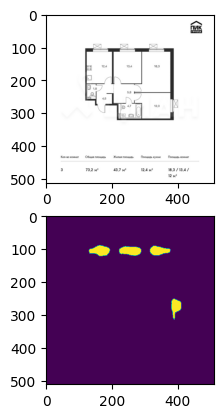

In [4]:
import matplotlib.pyplot as plt

## Необходимые вспомогательные функции
def get_test_augmentation():
    return A.Compose([
        A.Normalize(mean=(0.5,), std=(0.5,)),
    ], p=1)

def mask_to_grayscale(masks) -> np.ndarray:
    masks = masks.cpu().numpy()

    img = np.zeros(masks.shape[1:], dtype=np.uint8)

    img[masks[0] == 1] = 2

    return img

def tensor_from_rgb_image(image: np.ndarray) -> torch.Tensor:
    image = np.moveaxis(image, -1, 0)
    image = np.ascontiguousarray(image)
    image = torch.from_numpy(image)
    return image

def convert_image(img):
    if img is None:
        return
    height, width, channels = img.shape
    rect = (0, 0, 512, 512)
    h = rect[3]
    w = int(h * width / height)
    if w > rect[2]:
        w = rect[2]
        h = int(height / width * w)
    new_img = cv2.resize(img, (w, h), interpolation=cv2.INTER_AREA)
    s = np.full((rect[3], rect[2], 3), np.uint8(255))
    sy = int((rect[3] - h) / 2)
    sx = int((rect[2] - w) / 2)
    s[sy:sy + h, sx:sx + w] = new_img
    return s

## Загрузка модели
model = smp.FPN(encoder_name='resnet50', classes=24)
model.load_state_dict(torch.load("./model_2", map_location=torch.device('cpu')))
model.eval()

##Загрузка тестового изображения
image = cv2.imread(f"{os.environ['HOME']}/train/test.png")
converted_image = convert_image(image)
## Вывод исходного изображения
plt.subplot(211)
im1 = plt.imshow(converted_image)

## Применение сегментации
transform = get_test_augmentation()
image = transform(image=converted_image)['image']

image = tensor_from_rgb_image(image)
image = image.view((1, 3, image.shape[1], image.shape[2]))
with torch.no_grad():
    predict = model(image)
predict = torch.sigmoid(predict) > 0.2
res = mask_to_grayscale(predict[0])

## Вывод результирующего изображения
plt.subplot(212)
im1 = plt.imshow(res)


In [5]:
for i in res:
    print(i)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [59]:
from PIL import Image
import numpy as np
import os 
model = smp.FPN(encoder_name='resnet50', classes=24)
model.load_state_dict(torch.load("./model_2", map_location=torch.device('cpu')))
model.eval()
for filename in os.listdir('test_dataset_test'):
    print(filename)
    image = cv2.imread('test_dataset_test/'+filename)
    converted_image = convert_image(image)

    ## Применение сегментации
    transform = get_test_augmentation()
    image = transform(image=converted_image)['image']

    image = tensor_from_rgb_image(image)
    image = image.view((1, 3, image.shape[1], image.shape[2]))
    with torch.no_grad():
        predict = model(image)
    predict = torch.sigmoid(predict) > 0.2
    res = mask_to_grayscale(predict[0])
    im = Image.fromarray(res)
    im.save("result2/"+filename)
    ## Вывод результирующего изображения


2c215817-ec92-463d-803e-676d520a7a95.png
e97df838-c3f6-4e36-99aa-49c2d70c1090.png
4c891928-37ee-4366-b33d-6da7c5f2a178.png
6e88a8a3-85b5-4e73-b0f9-e1e496b5bbdd.png
11ff3b08-7186-44ce-b597-849fe601884b.png
b256414d-3e16-4ab4-876a-f4618a839bf3.png
bb83b472-e47e-4dfc-88c9-0f8c74a104a1.png
55e29bc1-893b-44e9-98a3-4b5d5b391760.png
6af6c2ef-b0ab-44a9-a209-7a62930e69b5.png
7bb077d0-12d2-4296-b031-bf7c0ba6cb03.png
2d3a03a3-97b8-4a89-8735-00fbf6339d50.png
0ebbe4f0-46eb-422a-8993-3cc87e25ba18.png
1a76f286-b226-4fb0-a480-948129b2b796.png
6e9ece5a-07d9-4f87-b04a-10e73b940fa4.png
0549aa45-6f53-4f7f-9b92-b4c34752723a.png
111c34c8-9630-4ec4-8777-34dbb3e08914.png
8ab96317-37d0-4e5a-8a8b-a73b9691b9f4.png
53824886-2ac5-4999-ac46-c3f79cf71037.png
574e6b9d-5055-4b52-9875-a1a19adb6fbc.png
1e941a8e-44e1-4db4-8a74-78927b9b5f74.png
b2298b82-9822-4e41-923e-ddcff0e453a0.png
5b5a6c7a-c54f-44ef-b10b-2d497a8d2bd8.png
e55f58d7-7e12-46ac-a973-61188f528845.png
b2f574d6-30e0-4518-abbc-ecc4b3a2f747.png
5d237c54-9044-43

faf2b444-94fe-4864-a16b-d9b389e8c71f.png
7f6009af-c441-481f-8cf3-cfa504ed019c.png
5db4b307-1f9e-45e6-ad9a-839149dfd5a0.png
0a6d6e92-1692-43e3-bcbf-035229ee830d.png
f7ce6db9-0843-4947-a0b4-96b69f197f07.png
6f8699e4-dc96-4f21-9820-55070c39cc8d.png
4a88a0c6-2334-4423-82ba-97afd422563b.png
39e91ce1-1a14-4f63-becc-e30283a1ad16.png
1f19e233-398a-40f0-9a30-17e94d66e767.png
eeb7905a-9e1d-46ee-bd41-a17130a877ae.png
5b67f277-75bb-4249-8f66-93efda9fbd22.png
b1ed73c1-bc6e-42d9-86f9-b93645e22cef.png
33920797-e306-4cb5-ac2f-a48ce7852a2e.png
c4003dd0-44c5-45d0-8eef-4ab4b9641fb9.png
11325bc0-3eac-4479-aec9-38851f668a11.png
046d5865-008d-4c3a-bd7a-db044eefbb59.png
2fb71a57-2853-41c8-a539-a2c4ac5cbb7e.png
3dcbddcc-c012-44ad-b3fb-b4eae3d76b40.png
3aa56090-54e6-4efa-a472-f7f30da46a09.png
0debd854-6aa3-4960-b606-8a790e3a40a7.png
c8353332-ae50-454a-96d5-c5323613842d.png
f6f0ece6-435c-4cb6-b05f-ffa07b3b912d.png
1fb6d7ae-bf09-49aa-8b4e-26e6bc42ba4f.png
3f2ba367-9810-44c1-a5f7-e303c772725b.png
2aac7b42-fd0a-47

0afcd362-12d3-4eaa-b0ae-b5e56f3e10e2.png
69a68a39-acd0-45ae-9ce8-7bde00e0c8aa.png
7d56eb17-47aa-4185-a32f-12345236567e.png
69a71db5-fd24-4c47-a221-452281b57c98.png
572d54df-4022-47cc-b751-3c139bdc0bd2.png
4370f4e9-29d7-4fb5-b0c1-194aa88cb62f.png
12fdd34f-97ff-4f59-ab8f-ad4172369ea8.png
7f15aa4b-828d-4a42-9a87-91de5c3abe32.png
6c38904c-506e-4642-8343-9397b4dac6b3.png
96b7005a-eb13-4d1c-87e3-84707387f279.png
8fa9fd64-9973-487e-8b3e-95fcdd9d3bf9.png
668f1573-60f5-462b-a685-e4d6126a658f.png
f02bd44b-8dc6-4341-ab75-0b16676e8e3d.png
93ae36c8-25f7-480f-bf22-0eccf3f503c3.png
5a6513b4-0ea6-4699-902d-d01b21a06a9d.png
c24e7115-e088-4799-b855-61fba00e5305.png
879cbf9d-0a2c-43e9-a93d-416419879abc.png
9c64010e-2a1c-4d2d-8770-dbb2f598edd2.png
1c0422b2-ed63-43bc-8d54-026e19c0e12f.png
43e46bea-2947-4363-8075-77fafd952b32.png
0c110a45-1a9e-471e-8f03-ef612c6ffd77.png
1394020f-e628-4388-9cfd-1b5b66b718d2.png
0e7cc13e-36a6-41d0-a70f-a1aa35164c0e.png
3f360e77-43b2-41c4-93d8-8f05bd2b118b.png
8d8a20eb-134f-40

73786101-3c9d-49f6-98b4-cc6d3614ef8c.png
d233f454-db61-4fab-a92d-154b0334b315.png
54ad9f63-d5e0-4717-a571-ac889ff40e5a.png
f492d698-1879-46bb-8082-038357fec07e.png
92dd3b87-4dcf-4281-aa6a-1bb4df160c84.png
56cd12ba-5e40-4128-b4c6-ab8629eec651.png
0d26f2a9-4358-415e-be96-b51ba3fabefe.png
b3b7a010-b83d-4b2b-92d0-f652b169066c.png
66b441e7-50eb-47de-8adc-e5192b1e5923.png
9c8e8543-d8fc-4b17-814c-72e2b31c5c99.png
977dfe10-7316-4c1e-ba05-e98d67207c63.png
b1c2914e-fec6-439f-b580-da32ab43c0af.png
19e8fc76-9141-40a0-ae0b-a8884a43cd03.png
951304cf-d047-4f88-a179-0fcdbbd24f3c.png
27f1bc3b-536a-4026-8cc4-9c1e7c383f0e.png
1f5dbde9-a1cd-4922-aa72-0ae5f0c322fd.png
2b854ea1-5eaa-460d-9e9d-b599fef4ca4f.png
29bb54c8-bad9-4058-8864-cad7a5938d46.png
0ed4bd73-018e-4d23-a885-7b1c36c65641.png
95d73f7f-c8d0-4308-92d0-f33a1800ec62.png
570eb9ca-9e86-4e2b-9c95-8eb2ccb30df7.png
d50f7c00-774e-41dd-bda4-c39930c48ad3.png
5da4aea8-a41d-4d39-b7cb-42332dec236d.png
2296011c-1eae-40fa-94ff-568f6efba7c4.png
f6c831e6-b492-46

88cb262b-39aa-4cf5-838b-7c75fa1ce0ef.png
873cd0e2-7828-4c29-ab90-eaac552fa967.png
5c9a87d0-8dba-46ef-a0a5-6228df134b2b.png
ba06ddde-dd22-452c-8208-fb26629237d2.png
1099dc9f-346d-4f8d-9afa-bf9ff181ed5b.png
ef0068f0-de3c-4f62-b35e-935184176a3d.png
d771b8de-f0b9-4489-9124-8c6334375968.png
6c1f4a64-cae8-4f1f-adf4-ba05a1647fbd.png
6ac84d82-abe0-4317-84b9-4faf92a9bb2f.png
ba0169e9-4a9a-491a-82cb-8867b7e5a9f9.png
5bc59618-aefb-4ac0-a2f1-d05e145262d7.png
779b0c6b-6429-466d-a78f-2d412bc43d64.png
e15d8b73-dbc6-444e-a7cc-3d1d05c0720c.png
20b8fef9-0f18-4a92-8a9d-d11dc0625bcd.png
3c36bc2d-775a-40b1-b009-b714a7ebd3bd.png
528c90ca-5abf-4b09-ab60-0d635cacfb4b.png
6f8a5689-fa45-4376-a6c8-d91374b4c43b.png
71816237-eb82-4c2f-8d2c-c31e8c9ef779.png
2537f9bb-202c-47cb-8872-b5ff52cc3d2f.png
6d8e445b-00ed-4d2d-80dd-7ef0d755bdac.png
84e6c2bb-bcb2-4a43-83b3-6158c47a2187.png
2bbaab7e-44bb-4a48-933c-6de2b765a7fc.png
54ccc2d4-fa35-41b9-9c04-20c5e7efe007.png
503ed10a-167b-4449-afaa-108e77a22349.png
9a422cb7-dfa0-43

1ba82381-b1ec-40d5-947c-9245b0467688.png
772e654e-4aaa-4a28-8e63-12d1bc654a7f.png
86b87252-610f-4787-b9c6-999fa68f2baf.png
9dfb74cf-8e1b-4c59-8d12-cf6514bd5543.png
b8b76493-1800-4555-95ba-4d6da6a698ce.png
07e3e9fd-357c-4744-80fd-249b4bd8e5fe.png
c9b9dca0-defc-4739-9df5-6ed53a8959d5.png
784e040c-87a4-4708-abf8-7f1deaaf4cd1.png
0fa023ec-1c6f-4d46-90ea-8e50fc432c84.png
95ff1da5-ada8-401f-8faa-44b45b5d5765.png
b1751ae3-1a0d-4de6-b1ab-efdaf6982fe2.png
68c03389-97dc-43d5-a245-2642bfbf54d1.png
a6f24767-d315-4a09-9a39-cf7d4040dd60.png
373d4d54-a218-4abc-b296-ea314a851fe4.png
7b3a147a-0252-4fd2-a361-7c1d9cc1b559.png
4fcce3f3-8279-47a4-b98d-f31169ded4a1.png
455d37c5-322a-449d-b4c5-2c4a87b5fef3.png
a5cad352-03d2-4173-ba00-2c24cc1c3b71.png
f8ac28c0-a3c4-4289-8aa9-243fcac9734a.png
5dfaafea-d625-41db-83c9-138a7472bd86.png
311e38f6-387e-419f-b58b-c607afdc1388.png
8d960a91-7c14-4d97-a28e-dec28ece4dec.png
2ccb9bd5-6b36-45d4-aa90-794dddc2bf26.png
5ae1eb2d-adc6-447c-bf87-8b89af22c7ea.png
a30ea7bb-ddd0-47

846f64da-f3e1-41a7-8ad0-29a8c4b81e3a.png
dbad1540-3577-4ba8-93bf-d199d46cb3c0.png
42f315c5-0408-4c5c-8dd6-64abf1a310ce.png
b49de07b-0c11-491a-9445-09005c625fbf.png
791c9e84-c47e-486f-923a-86b523976915.png
a5fb3a2b-c4d5-4cf2-864e-273cdfb338f5.png
2009e98d-518b-4cc0-ba74-24190f96b91b.png
9e002324-e977-4249-a967-a3a0b105a43a.png
1de7f3f8-b2aa-4bb6-af5b-bf689ace8dbf.png
1cfcf405-2f80-4350-a5e3-6d2f28ca7f72.png
2c7719df-c413-43e2-804c-773677e5fa11.png
7b71d841-497f-49be-b9c5-f62295c304dd.png
752e73db-e727-4724-ab66-beab1dcaf8ec.png
b9991c8e-cd41-4d50-a78a-f982c75eec79.png
2b18082a-6011-498f-be39-781473766e9d.png
eda1b0d7-f3da-4159-b5ca-c4b5b3c7f2ce.png
a7b94aae-6947-47e9-9d74-8ae66162863f.png
fdf709ef-5c6f-4bd2-8739-67ac9039e9aa.png
62820748-c701-4713-a1aa-1d4aaafbdb95.png
b47320e3-ed02-4aee-8ee4-cc750e9da8ae.png
88203765-7dde-4d9a-9e74-8857af0dec33.png
6a2a8ff1-ad0d-4db3-92c7-e1996c4f9d3a.png
2d2f875f-a3ca-42de-992c-9d004422fb66.png
1ae12fe7-1992-40f7-ad6f-315d61422130.png
0c340d70-499a-48

f5ceb79b-ec3e-4f82-aeef-99e1bc139544.png
de171555-fcde-48e1-9d11-b5f16a3997a8.png
ac5a4c95-3f20-4d91-ad4d-abba8f42b8e2.png
8f0d4a50-7194-4e01-891d-d550d26fef1b.png
a87a82e6-48ff-4972-846b-4d21ba2476e0.png
79f1157b-629b-4445-94f8-82b723754621.png
63fb7550-019b-480f-940d-7fca5b9ca8a8.png
736d4633-2bbd-4b21-bbdb-97006256c7ca.png
b3ea3ea1-31a2-416d-81d6-6e58240bd42f.png
3602f284-fb14-4390-a194-9bb4e4b761ce.png
1e00c926-d3da-4c76-bfcb-c3fb958eae9f.png
d8b67d44-74f4-4698-8af4-5a05ea503ee0.png
5af1ffde-ca41-42c9-8fa3-2cd172650204.png
70ff243c-9566-4a01-9370-75f3d9a1387b.png
5b9fd4c6-f20e-4535-9164-b021a30a0c71.png
74c87ab8-c594-4369-b489-0226f1e9f395.png
2a3cef40-88ad-4892-9110-a5b963f9def9.png
9199de2a-70a8-44a1-9873-28c3eaec4ea1.png
4ac6f8a4-957b-4be7-aee6-f40019dbe356.png
f6fbd640-6743-4601-b00a-886894b17572.png
c11f8f17-1b0a-44ae-bbed-a9b0e097482d.png
458c816e-7970-4be6-be55-f7327293a59a.png
c6203365-655e-4335-b1bf-dfc14b393e1d.png
72e49fc0-b68f-465b-9858-ffb450762ebd.png
bc5341a0-c6da-48

In [60]:
res

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [61]:
image1 = cv2.imread('result/'+'00a5e64d-2ca8-4083-bc5e-9c45127bba7e.png')
image1.shape

(512, 512, 3)

In [62]:
image2 = cv2.imread('result2/'+'00a5e64d-2ca8-4083-bc5e-9c45127bba7e.png')
image2.shape

(512, 512, 3)

In [63]:
for i in image1+image2:
    print(i)

[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]

# Сольем 2 файла в один!

In [64]:
for filename in os.listdir('result'):
    print(filename)
    img1 = cv2.imread('result/'+ filename)
    img2 = cv2.imread('result2/' + filename)
    res=img1 + img2
    res[res == 3 ] = 2
    cv2.imwrite("result3/"+filename,res)

2c215817-ec92-463d-803e-676d520a7a95.png
e97df838-c3f6-4e36-99aa-49c2d70c1090.png
4c891928-37ee-4366-b33d-6da7c5f2a178.png
6e88a8a3-85b5-4e73-b0f9-e1e496b5bbdd.png
11ff3b08-7186-44ce-b597-849fe601884b.png
b256414d-3e16-4ab4-876a-f4618a839bf3.png
bb83b472-e47e-4dfc-88c9-0f8c74a104a1.png
55e29bc1-893b-44e9-98a3-4b5d5b391760.png
6af6c2ef-b0ab-44a9-a209-7a62930e69b5.png
7bb077d0-12d2-4296-b031-bf7c0ba6cb03.png
2d3a03a3-97b8-4a89-8735-00fbf6339d50.png
0ebbe4f0-46eb-422a-8993-3cc87e25ba18.png
1a76f286-b226-4fb0-a480-948129b2b796.png
6e9ece5a-07d9-4f87-b04a-10e73b940fa4.png
0549aa45-6f53-4f7f-9b92-b4c34752723a.png
111c34c8-9630-4ec4-8777-34dbb3e08914.png
8ab96317-37d0-4e5a-8a8b-a73b9691b9f4.png
53824886-2ac5-4999-ac46-c3f79cf71037.png
574e6b9d-5055-4b52-9875-a1a19adb6fbc.png
1e941a8e-44e1-4db4-8a74-78927b9b5f74.png
b2298b82-9822-4e41-923e-ddcff0e453a0.png
5b5a6c7a-c54f-44ef-b10b-2d497a8d2bd8.png
e55f58d7-7e12-46ac-a973-61188f528845.png
b2f574d6-30e0-4518-abbc-ecc4b3a2f747.png
5d237c54-9044-43

4abd2cde-75a9-44b0-bf8e-e846f1826492.png
7c84aac0-368a-41e1-8e1d-c7499331fe5c.png
869f889a-5a9c-4c30-a4a9-df7c28b8d2cc.png
ffac839b-88c9-4fbe-ba2d-9e5e38415fb5.png
59ceb2b4-a489-4642-b095-64a110a70f89.png
8ccdaece-5d0a-4934-b757-fb5c4e6bde65.png
7cb30a83-9b43-45b2-a4f0-0c8e206b1b85.png
2a8559ec-66f9-4094-b2aa-d45c6878ced1.png
cdfc10f2-09f1-4037-8e37-0dd36d783f68.png
da6a713d-80e7-4475-8cb0-f9f777dd89b2.png
24cb604d-e1cb-4028-a40b-882b8b9dbce6.png
5ca971a2-5261-4f01-be9a-55d6ae69ee90.png
531175a5-da54-4598-9641-605f9399d76f.png
5d0456b8-489b-4760-97f0-405ec38b2408.png
0bd22bd2-2e3f-43fd-ac2a-acd0d492ec36.png
a732fc77-304d-4811-826b-d0bb2849c2fc.png
967d4861-b8aa-4c44-ad66-371811427e97.png
0ad2c525-6e2c-48b9-b71f-5e667062b8fe.png
0ca99b98-3942-453e-9780-171073b30ea3.png
703ebab7-eef9-462b-9f68-72072927b244.png
0ef0759a-44ea-4afa-9448-f147e4785ed1.png
6fb88008-9525-45c2-a5ae-a5da635e2d34.png
52a0ce04-6633-4987-8f87-5bf0165fcfca.png
a69b1eb3-bc1a-41db-b14b-74de2b9d8c15.png
5ae569f0-42d6-4a

92c8487f-83dc-4d12-bd6b-543e4419a714.png
0bbbeb41-a4ca-4dc9-ac30-f99653af5711.png
0318e3eb-86b4-484e-9e8b-4d6e4a0b7c9c.png
0e347348-b519-44e2-a6fc-b8334f36f97c.png
b0e11fc2-5d10-4502-b4ee-51d5c44b0d6a.png
83d7ea0c-8f40-4342-b934-9fe0188ff42e.png
281e96e8-e26a-4178-9b5d-947efb221579.png
5edfd107-27e4-4f10-be37-756b6b6f9697.png
48b395b2-a64b-4ebd-be11-08e4ff8e8390.png
4c27e891-f348-4694-b7f0-b4f006afe8b2.png
88b659f7-2ab7-4102-812a-ef0b6540b766.png
5b2d370d-3536-42fa-bce6-30439c0461a9.png
04ad10ba-6412-4a8e-b7a6-485af0ac8a17.png
97403c18-622c-4bb5-bc44-4e46a8b6f292.png
5bd7959d-c09d-4a4a-83e4-0f76942c0765.png
00c5993e-279c-4adc-9273-da02897fa2e2.png
b94f1109-8774-4d50-b14e-1e7cef6d5922.png
21f8f512-2d2b-48cb-85c0-fe8f7b23a4b0.png
dd1a156e-5271-4cee-bac9-1ad2627eb7b3.png
65af7570-da06-40ca-a36a-72e56547fb3b.png
62bd8185-83db-4f1b-9514-1ffae815e39f.png
1c9bc3e5-2050-4a55-8c77-7151209ced36.png
53e471ad-e8bd-47d5-90b6-8facac8d3139.png
331b8329-c3ad-4e7f-a65a-b851489a14c8.png
28509e65-fcb5-49

40d31612-c8bd-49f1-9b40-fd68c4f76491.png
2c50950a-ac37-4ab3-9703-e47de511268c.png
5a209ffd-e250-460b-b1b8-1b5f4478de71.png
756aecea-f2b0-474b-9371-49ffe127f67f.png
0e0da85a-bcaf-442f-a47b-3d05bc7365bc.png
cd06e2ea-0b2c-44c6-8f93-c62e7a37ee1d.png
b92a8f9d-c7c8-4b6a-a92f-7f895f7fb355.png
1c918daa-e724-49ec-a3be-3c59c6431127.png
5f296a49-6c12-4b79-8a38-399792714ecc.png
5f334865-282a-40ba-bc1e-65071e268495.png
1cd01105-5a55-45fd-a480-693f815d26eb.png
82a1b73f-27e0-4d7e-8715-8657ceac830f.png
b2c993ac-848c-4d1a-b901-6add966aa95c.png
5c84224d-f64c-483d-a944-899d7e9dcea0.png
729a2382-7622-40af-8d4b-ce0d997f7d87.png
55e2b29c-1a5e-4677-bc98-1875923220a5.png
ba1cb493-ce2b-40c1-bdf4-73c018db1d81.png
5fca8e59-8a61-43fe-9dab-50867edcecfc.png
87fd5c43-4030-4420-801b-5d08badd2bfb.png
00e9142f-5e5b-4c8b-b833-9a9448fb5551.png
094f7756-4ec1-4965-b76f-848241d7c224.png
3bf53336-6ec1-4b41-8e65-5e234d2fb07d.png
515557f9-4374-4808-be6f-6b8f62e51ab4.png
016cb44e-9416-4aca-bfe6-f48202430d1b.png
7ca34c33-4cc2-49

1ccb2233-e7bd-48b7-b979-d3a0144692b2.png
edc2afc1-3826-4857-b6ce-e515180e91cf.png
b09e2613-8ff2-4caa-b483-2b7b82073ae8.png
747ebcb8-7694-4bdb-8427-5c68a15c57c6.png
0c2d854d-01e5-4b6e-ba78-1b443edcd784.png
0084f30c-5dc4-4e3a-a895-34676001be82.png
0502bd00-6a20-4d71-88c3-cbf00e93d180.png
2dbec700-78a2-4ca4-936c-882dcf405b12.png
b55d9784-d9e0-4014-8dd0-d2aaf1e06b07.png
fedc91dc-9543-4d80-944a-57e4470f1285.png
7b626722-8f63-496b-a61c-e72d619ce5b6.png
063d4ac5-94ab-4a02-a023-15423e133240.png
58c27103-82ad-44ac-954f-3cec14a6a0b6.png
1da05f64-6948-48e6-b271-fb303db3f36b.png
6ce9e362-e250-4826-94f6-0bc67c481215.png
3b4880c0-0aab-4b22-814f-14c536773bf3.png
b68a308f-dae3-4490-ba46-5834b2751a99.png
88f76112-01ab-456a-9798-9e4ee226da33.png
662409ce-c45b-4b17-9dfb-6cad3ea61020.png
b717e71d-9e69-4715-850c-63b18ccf927f.png
4fa6efcf-8202-499a-8941-935cb157dc82.png
9e113e53-73e4-4506-b3ea-af495afcf182.png
5c7e333b-2c54-4e2c-a8f1-7a59c74dd438.png
892f5591-31db-4036-a3ac-dc1fbc4ef67d.png
559d5964-7543-44

67b04900-d9cf-49c9-92b2-323b874bed6f.png
b638e75f-e5fb-48a9-af39-69756816888e.png
339b3273-b9be-4e6b-b5ca-9ace3ffde68a.png
04a50e7a-a305-4295-94c3-59c810d614ea.png
ac3b7d34-6368-486f-9302-d3982f51879d.png
b2b11220-dc6d-410e-ae18-86103b8a06b8.png
1fef1a73-96fe-4b24-ae58-8daff93cb6b5.png
b55fce6f-b686-4bd4-9dfb-6435c403e2da.png
a3cac82d-d27a-4167-80df-d097ff278c6d.png
6edaa521-9337-4816-ab13-7041a7e6e9ce.png
2e137fc4-96ae-47e9-9629-5eeb33b574ae.png
0e4a3bd4-f374-449b-a333-e31815e31780.png
76312354-cc0d-4738-ac20-b82ea7511914.png
801d0b90-ec0e-4971-a835-783ce526b2d6.png
48e8d2de-cea5-4d11-a53a-dbf5ab8e18af.png
c0803501-e463-4081-93d9-b54195bf9800.png
395986a1-9649-4f2d-a22c-db42ab4a79f3.png
4f30b944-5657-45e6-a82d-61b42a203430.png
8c09c0b8-8a35-4cbc-b8d9-fbd8447c9871.png
f03f89e0-b208-4747-b0b9-cf2b2bab22a2.png
f46f7194-1c0f-46fd-9e5e-25bb821b732d.png
4db071d1-4186-4658-ba99-70c4705ecf01.png
e4e20f2a-16cf-4945-8fd9-53ee0d5c7697.png
317d27b4-4f3d-446d-a6c7-317436fd5c65.png
8f803873-7b31-40

f231c1f2-b783-4700-992a-7cdb1d785e20.png
0e21624c-e546-471f-8706-2d83f13f5c23.png
2f7da534-4cd4-42f1-9624-2d54a51ed51e.png
b79fed80-b074-4061-a841-caf66679ca12.png
b65afc13-e4cd-498e-8784-d6320f641d87.png
c406fe75-416c-405c-8d8a-2eba21135449.png
aaaa9c3c-0aab-40b8-9d5e-0ff89d8a815a.png
bf96b6a1-d0ef-48d7-a0dc-5ce9eb8df7d1.png
7fedb9f8-0279-4d1c-904d-a56e7487c871.png
086e1e95-ae62-4629-9fcc-1f8680c601fa.png
3006c572-545b-49c7-a5ed-e849863951a2.png
8bc3015b-64e6-4049-8dc5-f260df090658.png
b6b4fc9b-db7b-4494-ba96-548253d08c73.png
4af16453-e716-4f6c-92c4-6778b5204e17.png
465b204e-08be-4867-a718-3a713d57675b.png
d572b337-06a1-4b53-8be3-de7cea8b3c46.png
087bc49e-9d33-47f0-964a-637f77dd160c.png
3d64dc0b-d61a-49d3-84aa-ddca80dbeacd.png
d2314d78-50a5-4541-a367-5996c4991f28.png
8b39fc82-367c-4567-9ac1-44b99580acea.png
9f699748-bdc4-4af7-bb5d-54e5f32dc86b.png
708ac973-b002-4930-a0d1-a7152e7191ff.png
5f17e686-f26b-436b-bffd-f7af4106fc33.png
bb9c37ad-8a29-43a3-9031-37be2246beee.png
a46653a9-c4fb-46

3e47c7fe-29da-44cc-af61-e90a3799caee.png
07dcdfa7-f0c2-4265-8436-a6dfd053e4ea.png
5d8f8b42-09fa-4aed-a0f6-7b9943a40cdd.png
8b56e86d-b25d-4865-85aa-c446ccd76c2a.png
b2c36c85-12d5-4e2e-a29d-23dbba261db9.png
ab3256de-03e0-4311-a226-15e86a57cfb4.png
a27b3c38-92c2-4597-836f-3755dd0a9227.png
64dd557e-1cc7-437c-b046-71095fa0c8c9.png
80d6049f-d13d-47df-85d0-cc0923c97c00.png
b8aecc40-005b-43d9-9c3e-b8e0b9e06879.png
6073d238-a76b-47e9-be67-76519298f14e.png
24892f81-99c2-4df4-b0b7-e866480949ac.png
68b8b0f0-c9ae-4b71-bab0-db37a58cdb31.png
527a8e7d-f406-41e6-98ab-150bda031f64.png
5e558ada-86fc-4e14-acf7-b7ac3fa0254c.png
c4d55100-d281-4fd0-8463-ff8130388ecc.png
6d8e5a43-fb5b-4307-b44f-4ebbbc5290ed.png
ed66b336-2ff9-47ec-b3ca-abe8e4719b90.png
79e1e401-73d8-4539-9f2e-d4ba93de0cb5.png
c55aa9a8-f2ac-4d72-b241-6578c33f2fbf.png
b8f3a9ae-9c7e-4100-bc17-19e1c7b5aa6f.png
00ce438f-fc51-41c0-ab6f-3d6335fac59f.png
e8beaa8e-9bcb-44d2-bec5-3bc086d56230.png
1af2e8a6-c3e3-4e80-b6b9-1ef8d693a57f.png
0eeca3ba-8dda-4f

In [70]:
image = cv2.imread('result3/'+'2c6a0770-52f9-4056-a5cd-4c4db2a384f4.png')
image
print(np.sum(image==3))


0


Объявляем класс, используемый для обучения

In [13]:
class DetectionTrainer:

    def __init__(self, model: nn.Module, optimizer: torch.optim.Optimizer,
                 device: str, metric_functions: List[Tuple[str, Callable]] = [],
                 callbacks: List[Callable[[nn.Module, int], None]] = [], epoch_number: int = 0):
        self.model = model
        self.optimizer = optimizer

        self.device = device

        self.metric_functions = metric_functions
        self.callbacks = callbacks

        self.epoch_number = epoch_number

    @torch.no_grad()
    def evaluate_batch(self, val_iterator: Iterator, eval_on_n_batches: int) -> Optional[Dict[str, float]]:
        predictions = []
        targets = []

        for real_batch_number in range(eval_on_n_batches):
            try:
                xs, ys = next(val_iterator)

                xs = torch.tensor(xs, device=self.device)
                ys = [{key: torch.tensor(y[key], device=self.device) for key in y} for y in ys]
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break

            ys_pred = self.model.eval()(xs)

            for y_pred, y_true in zip(ys_pred, ys):
                predictions.append({key: y_pred[key].cpu().numpy() for key in y_pred})
                targets.append({key: y_true[key].cpu().numpy() for key in y_true})

        metrics = {}

        predictions_tensor = []
        targets_tensor = []

        for y_pred, y_true in zip(predictions, targets):
            predictions_tensor.append({key: torch.tensor(y_pred[key], device=self.device) for key in y_pred})
            targets_tensor.append({key: torch.tensor(y_true[key], device=self.device) for key in y_true})

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        return metrics

    @torch.no_grad()
    def evaluate(self, val_loader: DataLoader, eval_on_n_batches: int = 1) -> Dict[str, float]:
        metrics_sum = defaultdict(float)
        num_batches = 0

        val_iterator = iter(val_loader)

        while True:
            batch_metrics = self.evaluate_batch(val_iterator, eval_on_n_batches)

            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit_batch(self, train_iterator: Iterator, update_every_n_batches: int) -> Optional[Dict[str, float]]:
        self.optimizer.zero_grad()

        predictions = []
        targets = []

        for real_batch_number in range(update_every_n_batches):
            try:
                xs, ys = next(train_iterator)
                xs = torch.tensor(xs, device=self.device)
                ys = [{key: torch.tensor(y[key], device=self.device) for key in y} for y in ys]
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break

            loss = sum(self.model.train()(xs, ys).values())

            (loss / update_every_n_batches).backward()

            with torch.no_grad():
                ys_pred = self.model.eval()(xs)

                for y_pred, y_true in zip(ys_pred, ys):
                    predictions.append({key: y_pred[key].cpu().numpy() for key in y_pred})
                    targets.append({key: y_true[key].cpu().numpy() for key in y_true})

        self.optimizer.step()

        metrics = {}

        predictions_tensor = []
        targets_tensor = []

        for y_pred, y_true in zip(predictions, targets):
            predictions_tensor.append({key: torch.tensor(y_pred[key], device=self.device) for key in y_pred})
            targets_tensor.append({key: torch.tensor(y_true[key], device=self.device) for key in y_true})

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        return metrics

    def fit_epoch(self, train_loader: DataLoader, update_every_n_batches: int = 1) -> Dict[str, float]:
        metrics_sum = defaultdict(float)
        num_batches = 0

        train_iterator = iter(train_loader)

        while True:
            batch_metrics = self.fit_batch(train_iterator, update_every_n_batches)

            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit(self, train_loader: DataLoader, num_epochs: int,
            val_loader: DataLoader = None, update_every_n_batches: int = 1
            ) -> Dict[str, np.ndarray]:
        summary = defaultdict(list)

        def save_metrics(metrics: Dict[str, float], postfix: str = '') -> None:
            nonlocal summary, self

            for metric in metrics:
                metric_name, metric_value = f'{metric}{postfix}', metrics[metric]

                summary[metric_name].append(metric_value)

                print(f"{metric_name}: {metric_value}, Epoch: {self.epoch_number}")

        for _ in tqdm(range(num_epochs - self.epoch_number), initial=self.epoch_number, total=num_epochs):
            self.epoch_number += 1

            train_metrics = self.fit_epoch(train_loader, update_every_n_batches)

            with torch.no_grad():
                save_metrics(train_metrics, postfix='_train')

                if val_loader is not None:
                    test_metrics = self.evaluate(val_loader)
                    save_metrics(test_metrics, postfix='_test')

                with torch.no_grad():
                    for callback in self.callbacks:
                        callback(self.model, self.epoch_number)

        summary = {metric: np.array(summary[metric]) for metric in summary}

        return summary

Инициализация модели обучения и функций для подсчета метрик качества обучения нейросетей

In [14]:
def initialize_model(num_classes: int,
                     min_size: int, max_size: int,
                     image_mean: Sequence[float], image_std: Sequence[float],
                     device: str = None) -> torch.nn.Module:
    pretrained_model = fasterrcnn_resnet50_fpn(pretrained=False, min_size=min_size, max_size=max_size,
                                               image_mean=image_mean, image_std=image_std)
    num_predictor_features = pretrained_model.roi_heads.box_head.fc7.out_features
    pretrained_model.roi_heads.box_predictor = FastRCNNPredictor(num_predictor_features, num_classes)

    return pretrained_model.to(device)


def compute_iou(box1: torch.tensor, box2: torch.tensor) -> torch.tensor:
    x1 = max(box1[0], box2[0])
    x2 = min(box1[2], box2[2])
    y1 = max(box1[1], box2[1])
    y2 = min(box1[3], box2[3])

    if x2 - x1 < 0 or y2 - y1 < 0:
        return 0

    intersection = (x2 - x1) * (y2 - y1)
    sum_ = ((box1[2] - box1[0]) * (box1[3] - box1[1]) +
            (box2[2] - box2[0]) * (box2[3] - box2[1]))

    iou = intersection / (sum_ - intersection)

    return iou.item()


class MeanAveragePrecision:

    def __init__(self, num_conf: int = 11):
        self.num_conf = num_conf

    @staticmethod
    def is_true(box: torch.tensor, label: int,
                y_true: Dict[str, torch.tensor],
                iou_thresh: float = 0.5) -> bool:
        num_true = len(y_true['boxes'])

        for i in range(num_true):
            if label == y_true['labels'][i]:
                if compute_iou(box, y_true['boxes'][i]) > iou_thresh:
                    return True
        return False

    @staticmethod
    def compute_map_given_conf(y_preds: List[Dict[str, torch.tensor]],
                               y_trues: List[Dict[str, torch.tensor]],
                               conf: float) -> float:
        num_pos = defaultdict(int)
        num_true_pos = defaultdict(int)

        for y_pred, y_true in zip(y_preds, y_trues):

            num_pred = len(y_pred['boxes'])

            for i in range(num_pred):
                if y_pred['scores'][i] > conf:
                    label = y_pred['labels'][i]
                    num_pos[label] += 1

                    if MeanAveragePrecision.is_true(y_pred['boxes'][i], y_pred['labels'][i], y_true):
                        num_true_pos[label] += 1

        all_classes_sum = sum(num_true_pos[lbl] / num_pos[lbl] for lbl in num_pos)

        try:
            precision = all_classes_sum / len(num_pos)
        except ZeroDivisionError:
            precision = 0

        return precision

    def __call__(self, y_pred: List[Dict[str, torch.tensor]],
                 y_true: List[Dict[str, torch.tensor]]) -> float:
        assert len(y_pred) == len(y_true)

        map_sum = 0

        for conf in np.linspace(0, 1, self.num_conf):
            map_sum += self.compute_map_given_conf(y_pred, y_true, conf)

        return torch.tensor(map_sum / self.num_conf)


def minimum_bounding_box(points: List[List[float]]) -> Tuple[float, float, float, float]:
    x_min = min(p[0] for p in points)
    y_min = min(p[1] for p in points)
    x_max = max(p[0] for p in points)
    y_max = max(p[1] for p in points)

    return x_min, y_min, x_max, y_max


Классы, для формирования датасетов(для обучения и для тестирования)

In [15]:
class DataRetriever:

    def __init__(self,
                 dataset_path: str):
        super().__init__()

        self.dataset_path = dataset_path
        self.samples_paths = self.load_paths()
        print(f'Found {len(self.samples_paths)} samples')

    def remove_path(self, idx):
        del self.samples_paths[idx]

    def load_paths(self) -> List[str]:
        samples_paths = []

        for object_ in tqdm(os.listdir(self.dataset_path)):
            ext = object_.split(".")[-1]

            if ext != 'json':
                continue

            samples_paths.append(self.dataset_path + "/" + object_)

        return samples_paths

    def num_paths(self) -> int:
        return len(self.samples_paths)


class PLRCDataset(Dataset):

    def __init__(self, data_retriever,
                 class_ids: Dict,
                 transform: A.BasicTransform = None,
                 remove_unannotated: bool = False):
        self.data_retriever = data_retriever

        self.class_ids = class_ids

        self.transform = transform

        if remove_unannotated:
            print("Removing unannotated samples")
            num_removed = self.remove_unannotated_paths()
            print(f"Removed {num_removed} unannotated samples")

    def make_layout(self, shapes: List[Dict], image_size: Tuple[int, int]) -> Dict[str, np.ndarray]:
        shapes = self.select_shapes(shapes)

        boxes = []
        labels = []

        for shape in shapes:
            if len(shape['points']) < 2:
                continue

            label = shape['label']

            if label not in self.class_ids:
                continue

            x1, y1, x2, y2 = minimum_bounding_box(shape['points'])

            x1 = max(x1, 0)
            y1 = max(y1, 0)
            x2 = min(x2, image_size[1] - 1)
            y2 = min(y2, image_size[0] - 1)

            if x1 == x2 or y1 == y2:
                continue

            boxes.append((x1, y1, x2, y2))
            labels.append(self.class_ids[label])

        if len(boxes) > 0:
            boxes = np.array(boxes)
            labels = np.array(labels, dtype=np.int64)
        else:
            boxes = np.empty((0, 4))
            labels = np.empty(0, dtype=np.int64)

        return {'boxes': boxes, 'labels': labels}

    @staticmethod
    def select_shapes(shapes: List[Dict]) -> List[Dict]:
        good_shapes = []

        for shape in shapes:
            if shape['shape_type'] not in {'polygon', 'rectangle'} or len(shape['points']) < 2:
                continue

            good_shapes.append(shape)

        return good_shapes

    def remove_unannotated_paths(self) -> int:
        counter = 0

        for i in tqdm(range(len(self) - 1, -1, -1)):
            _, y = self[i]
            if len(y['boxes']) == 0:
                self.data_retriever.remove_path(i)
                counter += 1

        return counter

    @staticmethod
    def decode_image(encoded_image: str) -> np.ndarray:
        bytearray_ = np.asarray(bytearray(base64.b64decode(encoded_image)), dtype=np.uint8)
        return cv2.imdecode(bytearray_, cv2.IMREAD_COLOR).astype(np.float32) / 255

    def read_sample(self, json_path) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
        with open(json_path, 'r') as f:
            json_contents = json.load(f)

        image = self.decode_image(json_contents['imageData'])
        layout = self.make_layout(json_contents['shapes'], image.shape[:2])

        return image, layout

    def __getitem__(self, idx):
        sample_path = self.data_retriever.samples_paths[idx]

        x, y = self.read_sample(sample_path)

        if self.transform is not None:
            transformed = self.transform(image=x, bboxes=y['boxes'], labels=y['labels'])
            x, y['boxes'], y['labels'] = transformed['image'], transformed['bboxes'], transformed['labels']

        return x, y

    def __len__(self):
        return self.data_retriever.num_paths()


class DatasetPart(Dataset):

    def __init__(self, dataset: Dataset,
                 indices: np.ndarray,
                 transform: A.BasicTransform = None):
        self.dataset = dataset
        self.indices = indices

        self.transform = transform

    def __getitem__(self, idx: int) -> Any:
        x, y = self.dataset[self.indices[idx]]

        if self.transform is not None:
            transformed = self.transform(image=x, bboxes=y['boxes'], labels=y['labels'])
            x, y['boxes'], y['labels'] = transformed['image'], transformed['bboxes'], transformed['labels']

        return x, y

    def __len__(self) -> int:
        return len(self.indices)


Объявляем конфиг для object_detection

In [16]:
config = {
  "dataset_path": "train/object_detection",
  "model_log_interval": 1,
  "data": {
    "class_ids": {
      "door": 1
    }
  },
  "model": {
    "image_size": 512
  },
  "training": {
    "num_epochs": 2,
    "batch_size": 1,
    "update_every_n_batches": 1,
    "device": "cpu",
    "learning_rate": 1e-4,
    "num_workers": 0
  }
}

Код обучения

In [17]:
def make_transforms(config: Dict[str, Any]) -> Dict[str, Callable]:
    size = config['model']['image_size']

    train_list = [A.LongestMaxSize(size),
                  A.PadIfNeeded(size, size, border_mode=cv2.BORDER_REPLICATE),
                  ToTensorV2()]
    eval_list = [A.LongestMaxSize(size),
                 A.PadIfNeeded(size, size, border_mode=cv2.BORDER_REPLICATE),
                 ToTensorV2()]

    return {'train': A.Compose(train_list, bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])),
            'test': A.Compose(eval_list, bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))}


def make_datasets(transforms, config: Dict[str, Any]) -> Dict[str, Dataset]:
    all_data_retriever = DataRetriever(f"{os.environ['HOME']}/{config['dataset_path']}")

    all_data_dataset = PLRCDataset(all_data_retriever, config['data']['class_ids'], remove_unannotated=True)

    train_indices, test_indices = train_test_split(range(len(all_data_dataset)), test_size=0.3)

    return {'train': DatasetPart(all_data_dataset, train_indices, transform=transforms['train']),
            'test': DatasetPart(all_data_dataset, test_indices, transform=transforms['test'])}


def make_loaders(datasets, config: Dict[str, Any]):
    def collate_fn(samples):
        xs, ys = list(zip(*samples))

        for y in ys:
            if len(y['boxes']) == 0:
                y['boxes'] = np.empty((0, 4), dtype=np.float32)
            else:
                y['boxes'] = np.array(y['boxes'], dtype=np.float32)

            y['labels'] = np.array(y['labels'], dtype=np.int64)

        return torch.stack(xs), ys

    loaders = {}

    for name in datasets:
        loaders[name] = DataLoader(datasets[name], config['training']['batch_size'],
                                   num_workers=config['training']['num_workers'],
                                   shuffle=True, collate_fn=collate_fn)

    return loaders


def make_save_model_callback(log_interval: int):
    def save_model(model, epoch):
        if epoch % log_interval != 0:
            return
        torch.save(model.state_dict(), f"./model_obj_{epoch}")

    return save_model


if __name__ == '__main__':
    transforms = make_transforms(config)
    datasets = make_datasets(transforms, config)
    data_loaders = make_loaders(datasets, config)
    
    model = initialize_model(1 + max(config['data']['class_ids'].values()),
                             config['model']['image_size'], config['model']['image_size'], [0, 0, 0], [1, 1, 1],
                             config['training']['device'])
    optimizer = torch.optim.Adam(model.parameters(), config['training']['learning_rate'])

    metrics = [('mAP', MeanAveragePrecision())]

    trainer = DetectionTrainer(model, optimizer, metric_functions=metrics,
                               callbacks=[make_save_model_callback(config['model_log_interval'])],
                               device=config['training']['device'])

    trainer.fit(data_loaders['train'], config['training']['num_epochs'], val_loader=data_loaders['test'])

100%|█████████████████████████████████████| 100/100 [00:00<00:00, 864804.95it/s]


Found 100 samples
Removing unannotated samples


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 82.74it/s]
/home/genalll/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/genalll/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Removed 21 unannotated samples


  0%|                                                     | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_440850/2454098659.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xs = torch.tensor(xs, device=self.device)
  0%|                                                     | 0/2 [00:04<?, ?it/s]


KeyboardInterrupt: 

Вывод конечного результата

In [ ]:
import matplotlib.pyplot as plt
def draw_with_boxes(image: np.ndarray,
                    preds: Dict[str, np.ndarray] = None,
                    conf_threshold=0.5) -> np.ndarray:

    image = image.copy()

    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    font_scale = 0.7
    line_type = 1
    label_padding = 5

    num_boxes = len(preds['boxes'])

    for i in range(num_boxes):
        if preds['scores'][i] < conf_threshold:
            continue
        x_min, y_min, x_max, y_max = preds['boxes'][i]

        cv2.rectangle(img=image,
                      pt1=(int(x_min), int(y_min)),
                      pt2=(int(x_max), int(y_max)),
                      color=(0, 0, 255),
                      thickness=-1)

    return image

##Загрузка тестового изображения
image = cv2.imread(f"{os.environ['HOME']}/train/test.png").astype(np.float32) / 255

## Вывод исходного изображения
plt.subplot(211)
im1 = plt.imshow(image)

## Применение модели
class_ids = config['data']['class_ids']
reverse_classes_map = {v: k for k, v in class_ids.items()}
bytearray_ = np.asarray(bytearray(image), dtype=np.uint8)
x = image
transform = ToTensorV2()
model = initialize_model(1 + max(config['data']['class_ids'].values()),
                             config['model']['image_size'], config['model']['image_size'], [0, 0, 0], [1, 1, 1],
                             config['training']['device'])
model.load_state_dict(torch.load("./model_obj_2"))
x = transform(image=x)['image']
with torch.no_grad():
  y_pred = model.eval()([torch.tensor(x, device=config['training']['device'])])[0]
  y_pred = {key: y_pred[key].cpu().numpy() for key in y_pred}
  y_pred['labels'] = np.array([reverse_classes_map[label] for label in y_pred['labels']])

  x = torch.moveaxis(x, 0, -1).cpu().numpy()
  x = np.ascontiguousarray(255 * x, dtype=np.uint8)

image_with_boxes = draw_with_boxes(x, y_pred)

## Вывод реузультирующего изображения
plt.subplot(212)
im1 = plt.imshow(image_with_boxes)
